The upgrade:

- large tuned glossary
- '+' revision (multi turn)

In [15]:

from openai import OpenAI
import pandas as pd
client = OpenAI()
#User: simulates what a user might say to the model: input from the user in a conversation.
#Assistant: simulates the model's own responses.
#System: System messages are used to give instructions or settings that affect the model's behavior. 
    #These messages can define the context, persona, or specific instructions that the model should follow throughout the interaction.
 
df = pd.read_csv('verbs.csv')

def translate_verb(arb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert in Moroccan Darija dialect and in translating Darija to English." +
             "Purpose of the translation: To study the accuracy of LLMs on Darija," +
             "making sure that the language accounts for particular nuances of the language such as emphasis and articulation."+
             "Target audience: Darija Computational linguists"
            },
            {"role": "user", "content": "Translate the provided Moroccan Darija dialect verb into English using word-by-word translation."+
             "You must account for concepts such as articulation and emphasis in Darija and unique verbs to the language." + 
             "The output must not be an infinitive verb. No explanations are needed in the output"
             },
            {"role": "assistant", "content": "OK, I understand. I am ready for the verb translation."},
            {"role": "user", "content": "ولّا"},
            {"role": "assistant", "content": "become"},
            {"role": "user", "content": "ستدعا"},
            {"role": "assistant", "content": "summon"},
            {"role": "user", "content": "با"},
            {"role": "assistant", "content": "want"},
            {"role": "user", "content": "عنا"},
            {"role": "assistant", "content": "mean"},
            {"role": "user", "content": "شدّ"},
            {"role": "assistant", "content": "hold"},
            {"role": "user", "content": "غضب"},
            {"role": "assistant", "content": "anger"},
            {"role": "user", "content": "دار"},
            {"role": "assistant", "content": "do"},
            {"role": "user", "content": "عندو"},
            {"role": "assistant", "content": "have"},  
            {"role": "user", "content": "تسخسخ"},
            {"role": "assistant", "content": "exhaust"},
            {"role": "user", "content": "سلت"},
            {"role": "assistant", "content": "take off"},
            {"role": "user", "content": "تاوا"},
            {"role": "assistant", "content": "bargain"},
            {"role": "user", "content": "عام"},
            {"role": "assistant", "content": "swim"},
            {"role": "user", "content": "طلع"},
            {"role": "assistant", "content": "ascend"},
            {"role": "user", "content": "نقّص"},
            {"role": "assistant", "content": "reduce"},
            {"role": "user", "content": "قاس"},            
            {"role": "assistant", "content": "touch"},
            {"role": "user", "content":  f"{arb}" }
            ], 
            #
        temperature=0.1  # Deterministic responses
        )
    return completion.choices[0].message.content
def CoT_1(arb, translated):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a Computational Linguist expert."},
            {"role": "user", "content": "Check the semantic equivalence of the two provided verbs in Darija and English." + 
             "In case that the verbs are not equivalent: Re-translate the Darija verb to English." + 
             "In the case that they are equivalent output the English verb" +
             "The output must not be an infinitive verb. No explanations are needed in the output"},
            {"role": "assistant", "content": "OK, I understand. I will check your inputs for meaning equivalence." + 
             "In the case that the verbs are not equivalent, I will re-translate the Darija verb to English."+
             "Otherwise, I will output the provided English verb"},
            {"role": "user", "content":  f"{arb} / {translated}" }],
        temperature=0.1  # Deterministic responses 
        )
    return completion.choices[0].message.content
df['transl'] = df['darija_ar'].apply(translate_verb)

CoT = []
for arb, eng in zip(df['darija_ar'], df['transl']):
    translation = CoT_1(arb, eng)
    CoT.append(translation)

# Create a DataFrame to hold the results
CoT_df = pd.DataFrame(CoT, columns=['verb'])

# Display or save the resulting DataFrame
print(CoT_df)

            verb
0            eat
1          drink
2          enter
3          leave
4     Understand
...          ...
1027      inform
1028  Extinguish
1029       smell
1030       cheat
1031        peel

[1032 rows x 1 columns]


[('eat', 'eat', 1.0, True), ('drink', 'drink', 1.0, True), ('enter', 'enter', 1.0, True), ('exit', 'go_out', 1.0, True), ('understand', 'understand', 1.0, True), ('explain', 'explain', 1.0, True), ('read', 'learn', 1.0, True), ('read', 'teach', 0.25, False), ('hear', 'hear', 1.0, True), ('see', 'see', 1.0, True), ('smell', 'smell', 1.0, True), ('taste', 'taste', 1.0, True), ('measure', 'touch', 0.25, False), ('go', 'go', 1.0, True), ('arrive', 'come', 1.0, True), ('go_out', 'ascend', 0.3333333333333333, False), ('descend', 'go_down', 1.0, True), ('swim', 'swim', 1.0, True), ('drown', 'drown', 1.0, True), ('wear', 'wear', 1.0, True), ('take_off', 'take_off', 1.0, True), ('buy', 'buy', 1.0, True), ('sell', 'sell', 1.0, True), ('bargain', 'bargain', 1.0, True), ('write', 'write', 1.0, True), ('wipe', 'clean', 0.16666666666666666, False), ('hit', 'hit', 1.0, True), ('surrender', 'salute', 0.14285714285714285, False), ('tire', 'fatigue', 1.0, True), ('exhaust', 'exhaust', 1.0, True), ('laug

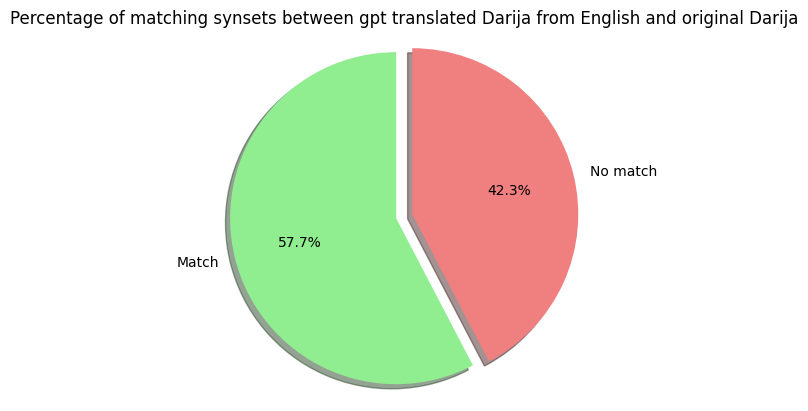

In [16]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn

eng = df['eng']
transl = df['transl']

transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score
# Calculate and print the path similarity for each pair of verbs with similar index

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
print(results)


# Extract the last element of each tuple in the list (representing True or False values)
last_elements = [result for *_, result in results]

# Count how many comparisons are True
true_count = sum(last_elements)  # True evaluates to 1, so summing directly counts the True values

# Calculate the percentage of True vs False
total_comparisons = len(results)
false_count = total_comparisons - true_count

# Plot pie chart
labels = 'Match', 'No match'
sizes = [true_count, false_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of matching synsets between gpt translated Darija from English and original Darija")
plt.show()


[('eat', 'eat', 1.0, True), ('drink', 'drink', 1.0, True), ('enter', 'enter', 1.0, True), ('leave', 'go_out', 1.0, True), ('Understand', 'understand', 1.0, True), ('I_will_compare_the_meanings_of_the_two_verbs_provided_in_Darija_and_English._If_they_have_the_same_meaning,_I_will_output_the_English_verb._If_they_do_not_have_the_same_meaning,_I_will_re-translate_the_Darija_verb_into_English.', 'explain', 0, False), ('Read', 'learn', 1.0, True), ('read', 'teach', 0.25, False), ('listen', 'hear', 1.0, True), ('شاف_/_look', 'see', 0, False), ('smell', 'smell', 1.0, True), ('taste', 'taste', 1.0, True), ('measure', 'touch', 0.25, False), ('walk', 'go', 0.5, True), ('arrive', 'come', 1.0, True), ('Leave', 'ascend', 0.3333333333333333, False), ('come_down', 'go_down', 1.0, True), ('swim', 'swim', 1.0, True), ('drown', 'drown', 1.0, True), ('wear', 'wear', 1.0, True), ('Remove', 'take_off', 0.5, True), ('Purchase', 'buy', 1.0, True), ('sell', 'sell', 1.0, True), ('Negotiate', 'bargain', 0.5, Tr

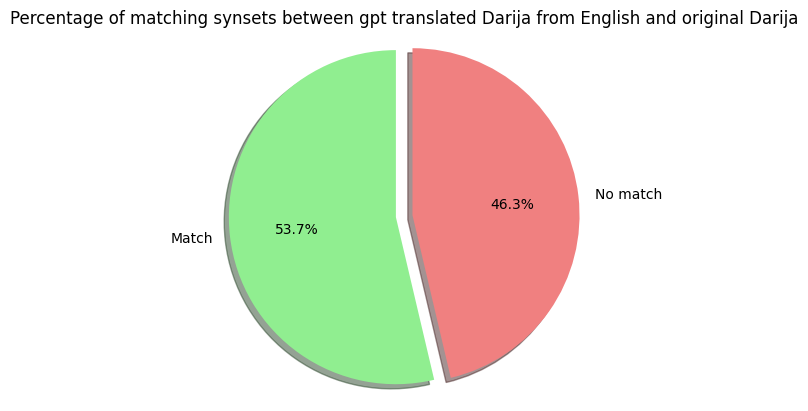

In [17]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn

eng = df['eng']
transl = CoT_df['verb']

transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score
# Calculate and print the path similarity for each pair of verbs with similar index

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
print(results)


# Extract the last element of each tuple in the list (representing True or False values)
last_elements = [result for *_, result in results]

# Count how many comparisons are True
true_count = sum(last_elements)  # True evaluates to 1, so summing directly counts the True values

# Calculate the percentage of True vs False
total_comparisons = len(results)
false_count = total_comparisons - true_count

# Plot pie chart
labels = 'Match', 'No match'
sizes = [true_count, false_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of matching synsets between gpt translated Darija from English and original Darija")
plt.show()



gloassary containing one of these and their meaning:
ammara 
fahhama


Baseline query:

In [1]:

from openai import OpenAI
import pandas as pd
client = OpenAI()
#User: simulates what a user might say to the model: input from the user in a conversation.
#Assistant: simulates the model's own responses.
#System: System messages are used to give instructions or settings that affect the model's behavior. 
    #These messages can define the context, persona, or specific instructions that the model should follow throughout the interaction.
 
df = pd.read_csv('verbs.csv')

def translate_verb(arb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert in Moroccan Darija dialect and in translating Darija to English." +
             "Translate the provided Moroccan Darija dialect verb into English using word-by-word translation."+
             "You must account for concepts such as articulation and emphasis in Darija and unique verbs to the language." + 
             "The output must not be an infinitive verb. No explanations are needed in the output." +
             "Purpose of the translation: To study the accuracy of LLMs on Darija," +
             "making sure that the language accounts for particular nuances of the language such as emphasis and articulation."+
             "Target audience: Darija Computational linguists"
            },
            {"role": "user", "content": "ولّا"},
            {"role": "assistant", "content": "become"},
            {"role": "user", "content": "ستدعا"},
            {"role": "assistant", "content": "summon"},
            {"role": "user", "content": "با"},
            {"role": "assistant", "content": "want"},
            {"role": "user", "content": "عنا"},
            {"role": "assistant", "content": "mean"},
            {"role": "user", "content": "شدّ"},
            {"role": "assistant", "content": "hold"},
            {"role": "user", "content": "غضب"},
            {"role": "assistant", "content": "anger"},
            {"role": "user", "content": "دار"},
            {"role": "assistant", "content": "do"},
            {"role": "user", "content": "عندو"},
            {"role": "assistant", "content": "have"},  
            {"role": "user", "content": "تسخسخ"},
            {"role": "assistant", "content": "exhaust"},
            {"role": "user", "content": "سلت"},
            {"role": "assistant", "content": "take off"},
            {"role": "user", "content": "تاوا"},
            {"role": "assistant", "content": "bargain"},
            {"role": "user", "content": "عام"},
            {"role": "assistant", "content": "swim"},
            {"role": "user", "content": "طلع"},
            {"role": "assistant", "content": "ascend"},
            {"role": "user", "content": "نقّص"},
            {"role": "assistant", "content": "reduce"},
            {"role": "user", "content": "قاس"},            
            {"role": "assistant", "content": "touch"},
            {"role": "user", "content":  f"{arb}" }
            ], 
            #
        temperature=0.1  # Deterministic responses
        )
    return completion.choices[0].message.content
df['transl'] = df['darija_ar'].apply(translate_verb)

[('eat', 'eat', 1.0, True), ('drink', 'drink', 1.0, True), ('enter', 'enter', 1.0, True), ('exit', 'go_out', 1.0, True), ('understand', 'understand', 1.0, True), ('explain', 'explain', 1.0, True), ('read', 'learn', 1.0, True), ('read', 'teach', 0.25, False), ('hear', 'hear', 1.0, True), ('see', 'see', 1.0, True), ('smell', 'smell', 1.0, True), ('taste', 'taste', 1.0, True), ('measure', 'touch', 0.25, False), ('go', 'go', 1.0, True), ('come', 'come', 1.0, True), ('go_out', 'ascend', 0.3333333333333333, False), ('descend', 'go_down', 1.0, True), ('swim', 'swim', 1.0, True), ('drown', 'drown', 1.0, True), ('wear', 'wear', 1.0, True), ('take_off', 'take_off', 1.0, True), ('buy', 'buy', 1.0, True), ('sell', 'sell', 1.0, True), ('bargain', 'bargain', 1.0, True), ('write', 'write', 1.0, True), ('wipe', 'clean', 0.16666666666666666, False), ('hit', 'hit', 1.0, True), ('surrender', 'salute', 0.14285714285714285, False), ('tired', 'fatigue', 1.0, True), ('shake', 'exhaust', 0.25, False), ('laugh

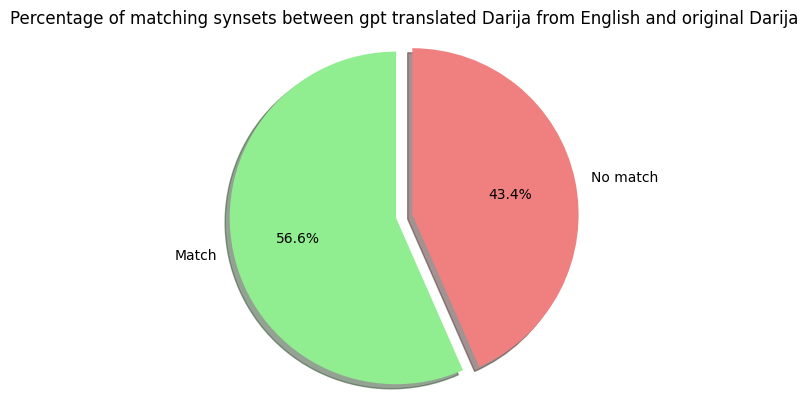

In [3]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn

eng = df['eng']
transl = df['transl']

transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score
# Calculate and print the path similarity for each pair of verbs with similar index

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
print(results)


# Extract the last element of each tuple in the list (representing True or False values)
last_elements = [result for *_, result in results]

# Count how many comparisons are True
true_count = sum(last_elements)  # True evaluates to 1, so summing directly counts the True values

# Calculate the percentage of True vs False
total_comparisons = len(results)
false_count = total_comparisons - true_count

# Plot pie chart
labels = 'Match', 'No match'
sizes = [true_count, false_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of matching synsets between gpt translated Darija from English and original Darija")
plt.show()